<a href="https://colab.research.google.com/github/folga67/data_mining/blob/master/OFedorova_hw_les2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

In [ ]:
import pandas as pd

Наши новости

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/articles.csv")
news.head(3)

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [ ]:
## uploaded = files.upload()
##import io
##news = pd.read_csv(io.BytesIO(uploaded['articles.csv']))

Загрузим пользователей и списки последних прочитанных новостей

In [ ]:
users = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [ ]:
##from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [ ]:
!pip install razdel

In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 8.2MB 19.0MB/s 


In [ ]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopword_ru = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

In [ ]:
len(stopword_ru)

151

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/stopwords.txt") as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [ ]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [ ]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 25.7 s, sys: 1.57 s, total: 27.3 s
Wall time: 27.3 s


In [ ]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 8s, sys: 697 ms, total: 4min 9s
Wall time: 4min 9s


А теперь в 3 строчки обучим нашу модель

In [ ]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [ ]:
common_dictionary[4]

'армеец'

Все просто - это словарь наших слов

Запускаем обучение

In [ ]:
common_dictionary.doc2bow(['баскетбол' ,'баскетбол' ,'наше', 'все'], allow_update=True)

[(6, 2), (141166, 1), (141167, 1)]

In [ ]:
common_corpus[0][0]

(0, 5)

In [ ]:
len(texts[3])

83

In [ ]:
N_topic = 15 # число тем - гиперпараметр

In [ ]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 43.9 s, sys: 17.8 s, total: 1min 1s
Wall time: 42.1 s


In [ ]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [ ]:
temp_file

'/usr/local/lib/python3.7/dist-packages/gensim/test/test_data/model.lda'

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [ ]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(3, 0.40401843), (4, 0.22669211), (9, 0.34977722)]

In [ ]:
lda[unseen_doc]

[(3, 0.40401965), (4, 0.22666198), (9, 0.3498061)]

In [ ]:
x=lda.show_topics(num_topics = N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: гражданин млн тыс составить участок рынок торговый
topic_1: исследование журнал исследователь nn пациент автор женщина
topic_2: цена рост доллар ставка налог тыс млн
topic_3: украина украинский пенсия киев следствие крым данные
topic_4: экономика всё мозг система температура новый министерство
topic_5: ген иск астроном астероид сократиться бомба опубликовать
topic_6: научный наука газета всё вопрос новый снижение
topic_7: земля восток убийство высота nn ветер место
topic_8: самолёт сша ракета американский россия российский территория
topic_9: луна взрыв исследование nn смерть солнце лаборатория
topic_10: учёный обнаружить тело день животное найти nn
topic_11: учёный проект первый большой газ университет фонд
topic_12: корабль нефть северный nn сша экипаж поверхность
topic_13: россия nn российский рубль млрд банк глава
topic_14: военный россия армия боевой турция войско российский


Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [ ]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [ ]:
s = lda[unseen_doc]
a = dict(zip([i[0] for i in s], [i[1] for i in s]))
a

{3: 0.40402165, 4: 0.22668327, 9: 0.34978282}

In [ ]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,6,0.0000,0.0,0.0,0.00000,0.020370,0.138192,0.000000,0.033345,0.0,0.000000,0.0,0.0,0.0,0.80193,0.0
1,4896,0.0000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.977236,0.0,0.0,0.0,0.00000,0.0
2,4897,0.0000,0.0,0.0,0.40402,0.226714,0.000000,0.000000,0.000000,0.0,0.349755,0.0,0.0,0.0,0.00000,0.0
3,4898,0.0753,0.0,0.0,0.00000,0.914382,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
4,4899,0.0000,0.0,0.0,0.00000,0.000000,0.176648,0.721964,0.000000,0.0,0.079767,0.0,0.0,0.0,0.00000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [ ]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [ ]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

NameError: ignored

In [ ]:
doc_dict[293622]

array([0.        , 0.05280609, 0.10998287, 0.        , 0.19431263,
       0.02904237, 0.        , 0.        , 0.10047234, 0.04019511,
       0.        , 0.12932739, 0.01455341, 0.24912383, 0.07659973])

In [ ]:
user_articles_list = users['articles'].iloc[33]
#user_articles_list = eval(user_articles_list)
user_articles_list


'[323329, 321961, 324743, 323186, 324632, 474690]'

In [ ]:
def get_user_embedding(user_articles_list, func):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = func(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

In [ ]:
##users['articles'].iloc[33]

In [ ]:
##" ".join(news[news['doc_id']==323329]['title'].iloc[0])

In [ ]:
# Определим список функций
res = []
funcs = [np.mean, np.median, np.max]
for func in funcs:
    item = {'func': func,
          'model': None,
          'user_embeddings': None,
          'X': None,
          'X_train': None,
          'y_train': None,
          'X_test': None,
          'y_test': None,
          'preds' : None,
          'thresholds': None,
          'precision': None,
          'recall': None,
          'fscore': None,
          'roc_auc_score': None,
          }
    res.append(item)

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [ ]:
for item in res:
     user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, item['func']), 1)])
     user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
     user_embeddings['uid'] = users['uid'].values
     user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
     
     item['user_embeddings'] = user_embeddings

In [ ]:
res[0]['user_embeddings'].head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,u105138,0.024557,0.050355,0.064411,0.008813,0.190642,0.083130,0.008530,0.023828,0.088166,0.024929,0.009583,0.086219,0.016419,0.165695,0.144409
1,u108690,0.032328,0.025218,0.075106,0.004060,0.216993,0.074808,0.015930,0.051122,0.045096,0.007798,0.148883,0.076889,0.049930,0.016347,0.152817
2,u108339,0.030023,0.018089,0.010316,0.015793,0.351524,0.078343,0.071597,0.044379,0.096762,0.015549,0.097555,0.001791,0.014118,0.012809,0.129515


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [ ]:
target = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/users_churn.csv")

In [ ]:
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [ ]:
for item in res:
    item['X'] = pd.merge(item['user_embeddings'], target, 'left')
res[0]['X'].head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,churn
0,u105138,0.024557,0.050355,0.064411,0.008813,0.190642,0.083130,0.008530,0.023828,0.088166,0.024929,0.009583,0.086219,0.016419,0.165695,0.144409,0
1,u108690,0.032328,0.025218,0.075106,0.004060,0.216993,0.074808,0.015930,0.051122,0.045096,0.007798,0.148883,0.076889,0.049930,0.016347,0.152817,1
2,u108339,0.030023,0.018089,0.010316,0.015793,0.351524,0.078343,0.071597,0.044379,0.096762,0.015549,0.097555,0.001791,0.014118,0.012809,0.129515,1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#разделим данные на train/test
for item in res:
    X = item['X']
    item['X_train'], item['X_test'], item['y_train'], item['y_test'] = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, test_size = 0.3)
res[0]['X_train'].shape, res[0]['X_test'].shape, res[0]['y_train'].shape, res[0]['y_test'].shape

((5600, 15), (2400, 15), (5600,), (2400,))

In [ ]:
for item in res:
   item['model'] = LogisticRegression(C = 0.5, solver='lbfgs')
  #обучим 
   item['model'].fit(item['X_train'], item['y_train'])
res[0]['model']

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#наши прогнозы для тестовой выборки
for item in res:
   item['preds'] = item['model'].predict_proba(item['X_test'])[:, 1]
res[0]['preds'][:10]

array([0.14541925, 0.03070233, 0.28470282, 0.24942388, 0.07104837,
       0.06725547, 0.15559584, 0.04539727, 0.10315445, 0.14480982])

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

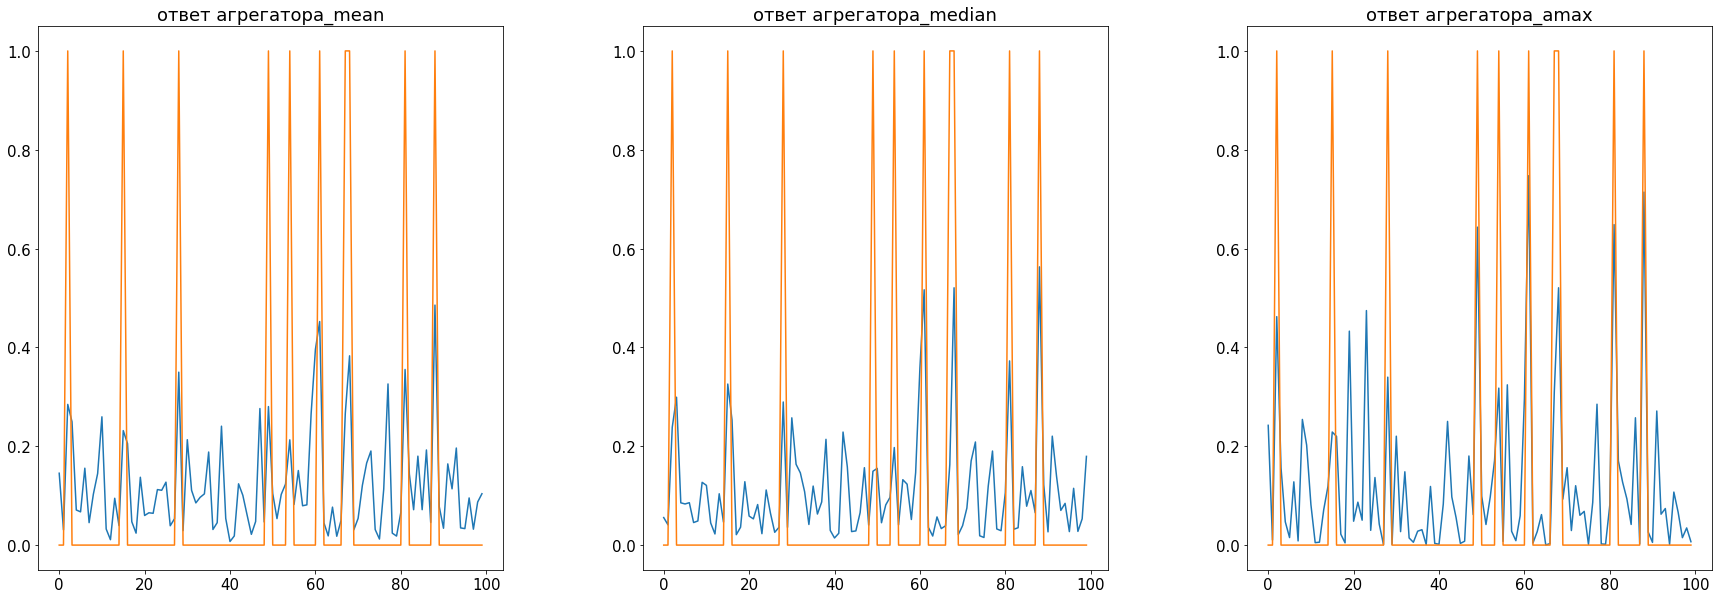

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax1, ax2, ax3 = ax.flatten()
ax1.plot(res[0]['preds'][:100], label = 'predict')
ax1.plot(res[0]['y_test'].values[:100], label = 'true')
ax1.set_title('ответ агрегатора_{}'.format(res[0]['func'].__name__))

ax2.plot(res[1]['preds'][:100], label = 'predict')
ax2.plot(res[1]['y_test'].values[:100], label = 'true')
ax2.set_title('ответ агрегатора_{}'.format(res[1]['func'].__name__))

ax3.plot(res[2]['preds'][:100], label = 'predict')
ax3.plot(res[2]['y_test'].values[:100], label = 'true')
ax3.set_title('ответ агрегатора_{}'.format(res[2]['func'].__name__))
fig.set_size_inches(30, 10)
plt.subplots_adjust(wspace=0.3, hspace=0.8)





In [ ]:
for item in res:
    precision, recall, thresholds = precision_recall_curve(item['y_test'].values, item['preds'])
    fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
    ix = np.argmax(fscore)
    item['thresholds'] = thresholds[ix]
    item['precision'] = precision[ix]
    item['recall'] = recall[ix]
    item['fscore'] = fscore[ix]
    ##print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        ##fscore[ix],
                                                                        ##precision[ix],
                                                                        ##recall[ix]))

In [ ]:
for item in res:
     item['roc_auc_score'] = roc_auc_score(item['y_test'], item['preds'])
res[0]['roc_auc_score']

0.9390735578301485

In [ ]:
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1957  150]
 [  83  210]]


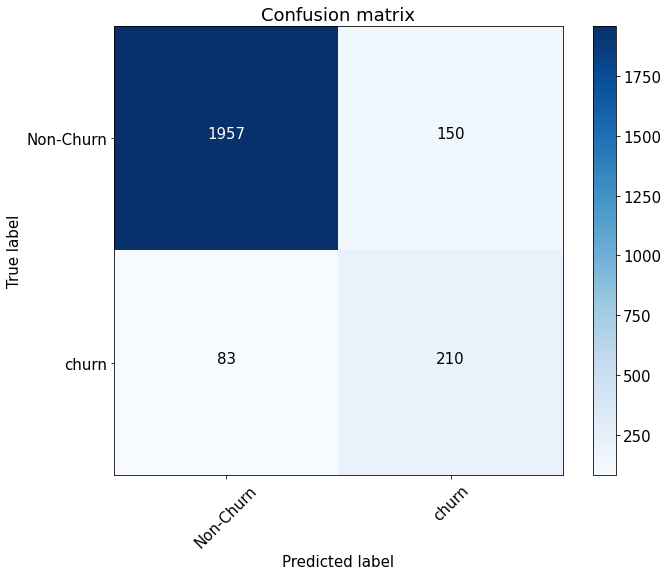

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(res[0]['y_test'], res[0]['preds']>res[0]['thresholds'])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
data = []

for item in res:
     data.append([item['func'].__name__, item['precision'], item['recall'], item['fscore'], item['roc_auc_score']])

summary = pd.DataFrame(data, columns = ['func', 'precision', 'recall', 'fscore', 'roc_auc_score'])
summary

,func,precision,recall,fscore,roc_auc_score
0,mean,0.584488,0.720137,0.645260,0.939074
1,median,0.728625,0.668942,0.697509,0.953602
2,amax,0.600559,0.733788,0.660522,0.941866


Самый высокий F_score и Roc_auc_score показывает модель агрегированная по функции mediana. Mediana более устойчива к выбросам по сравнению с mean. 
Так как агрегирование по функции max определеяет вектор user по самому яркому предпочтению темы в чтении user, показатель recall (глубины) самый высокий, однако данная модель хуже модели 'mediana' по сбалансированности  глубины и точности (f_score).


4. 
Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [ ]:
 articles = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/articles_idf.csv')
 articles.head(3), articles.shape, news['doc_id'].unique().shape

(   article_id       idf
 0          10  8.888710
 1         100  7.907880
 2        1000  8.041412, (14781, 2), (27000,))

In [ ]:
news.head(3)

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [ ]:
##articles_idf = pd.merge(news, articles['idf'], inner )
##articles_idf.head()
articles_idf_ =pd.merge(news, articles, left_on='doc_id', right_on='article_id', how="left", validate='m:1')
articles_idf_.head()
news_idf = articles_idf_.drop('article_id', axis = 1).dropna()
news_idf.head(3)

,doc_id,title,idf
1,4896,"[матч, 1/16, финал, кубок, россия, футбол, при...",8.195562
2,4897,"[форвард, авангард, томаш, заборский, прокомме...",8.888710
3,4898,"[главный, тренер, кубань, юрий, красножанин, п...",8.195562


In [ ]:
news_idf.dropna()

,doc_id,title,idf
1,4896,"[матч, финал, кубок, россия, футбол, приостано...",8.195562
2,4897,"[форвард, авангард, томаш, заборский, прокомме...",8.888710
3,4898,"[главный, тренер, кубань, юрий, красножанин, п...",8.195562
4,4899,"[решение, попечительский, совет, владивостокск...",8.195562
5,4900,"[главное, тренер, вячеслав, буцай, прокомменти...",8.601027
...,...,...,...
26975,513412,"[предложение, российский, космический, агентст...",9.294175
26976,513413,"[первый, общий, собрание, российский, академия...",9.294175
26979,513422,"[общество, научный, работник, начало, сбор, по...",9.294175
26998,513444,"[последний, тропический, углеродный, цикл, чув...",9.294175


In [ ]:
%%time
#Запускаем очистку текста. Будет долго...
news_idf['title'] = news_idf['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 11.3 s, sys: 35.5 ms, total: 11.3 s
Wall time: 11.3 s


In [ ]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news_idf['title'] = news_idf['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 2min 41s, sys: 372 ms, total: 2min 42s
Wall time: 2min 42s


In [ ]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news_idf['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [ ]:
len(common_corpus)

14781

In [ ]:
N_topic = 15

In [ ]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 20.3 s, sys: 7.52 s, total: 27.9 s
Wall time: 19.7 s


In [ ]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file1 = datapath("model1.lda")
lda.save(temp_file1)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file1)

In [ ]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news_idf['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['главный', 'тренер', 'кубань', 'юрий', 'красножанин', 'прокомментировать', 'победа', 'крыло', 'совет', 'матч', 'тур', 'чемпионат', 'россия', 'nn', 'второй', 'игра', 'подряд', 'получиться', 'заработать', 'преимущество', 'успокаиваться', 'передавать', 'сэ', 'пока', 'осложнить', 'жизнь', 'спокойствие', 'пребывать', 'наверное', 'конец', 'сезон', 'понемногу', 'отпускной', 'настроение', 'овладевать', 'игрок', 'менее', 'смочь', 'состояние', 'создать', 'немало', 'момент', 'целое', 'всё', 'неплохо', 'привыкать', 'команда', 'статус', 'лидер', 'наверное', 'команда', 'действительно', 'уверенно', 'чувствовать', 'возможно', 'частично', 'отсюда', 'идти', 'самоуспокоенность', 'вести', 'счёт', 'почему', 'выпустить', 'афолаби', 'первый', 'попасть', 'заявка', 'заменить', 'бальда', 'здорово', 'отыграть', 'хотеть', 'дать', 'закончить', 'матч', 'заменить', 'попов', 'требоваться', 'всё', 'замена', 'позиция']


[(1, 0.6266862), (5, 0.36274472)]

In [ ]:
x=lda.show_topics(num_topics = N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: исследование ребёнок учёный смерть исследователь жизнь женщина
topic_1: взрыв министерство россия первый якобы армия фонд
topic_2: всё область большой учёный научный район новый
topic_3: температура век учёный собор новый археолог сталин
topic_4: сотрудник задержать убийство район пострадать следователь уголовный
topic_5: институт мозг земля космический планета орбита луна
topic_6: военный россия гражданин всё российский экипаж первый
topic_7: украина украинский исследователь учёный обвинение nn женщина
topic_8: рак фестиваль nn сколково агентство татарин городской
topic_9: армия космос nn ссср премия ступень советский
topic_10: тыс nn наука российский млн роскосмос рубль
topic_11: обнаружить nn полёт первый опубликовать самолёт квартира
topic_12: россия сша самолёт глава территория nn государство
topic_13: статья следствие преступление ст журналист газета часть
topic_14: метод новый москва всё парк рассказывать животное


In [ ]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

    news_idf['title'].apply(lambda x: clean_text(x), 1)

In [ ]:
funca = lambda x: np.asarray(x) * np.array(news_idf['idf'])
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news_idf['title'].values]).apply(funca)
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news_idf['doc_id'].values
##topic_matrix['doc_idf'] = news_idf['idf']
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]##
topic_matrix.head(3)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,4896,0.0,8.008996,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,4897,0.0,3.015283,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.936073,0.0,0.0,2.763914
2,4898,0.0,5.135281,0.0,0.0,0.0,2.973661,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [ ]:
users['articles']

0       [293672, 293328, 293001, 293622, 293126, 1852]
1               [3405, 1739, 2972, 1158, 1599, 322665]
2               [1845, 2009, 2356, 1424, 2939, 323389]
3               [5933, 6186, 5055, 6977, 5206, 488389]
4                [707, 1144, 2532, 2928, 3133, 324592]
                             ...                      
7995     [323918, 323362, 323704, 323452, 324291, 251]
7996            [5532, 5860, 7755, 7140, 5182, 488337]
7997    [322811, 323898, 321858, 323345, 323491, 2193]
7998            [5436, 6092, 6891, 7045, 5320, 487379]
7999    [294096, 293759, 294178, 293544, 293921, 2909]
Name: articles, Length: 8000, dtype: object

In [ ]:
user_articles_list = users['articles'].iloc[0]
user_articles_list = eval(user_articles_list)
user_articles_list

[293672, 293328, 293001, 293622, 293126, 1852]

In [ ]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [ ]:
doc_dict[293672]

array([0.        , 0.        , 0.        , 2.00737499, 0.        ,
       0.        , 0.35873293, 0.        , 0.35726493, 0.        ,
       3.44369027, 0.        , 1.02608085, 0.        , 1.3086406 ])

In [ ]:
user_articles_list = users['articles'].iloc[33]
def get_user_embedding(user_articles_list, func):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = func(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

In [ ]:
user_articles_list = users['articles'].iloc[33]
v = get_user_embedding(user_articles_list, funcs[0])
v

array([0.06439661, 0.55102022, 0.27282479, 0.        , 0.91739099,
       0.        , 1.87375229, 0.53546701, 0.        , 0.07493637,
       0.35761891, 0.24570404, 2.58416237, 0.49061833, 0.05229753])

In [ ]:
# Определим список функций
res1 = []
funcs = [np.mean, np.median, np.max]
for func in funcs:
    item = {'func': func,
          'model': None,
          'user_embeddings': None,
          'X': None,
          'X_train': None,
          'y_train': None,
          'X_test': None,
          'y_test': None,
          'preds' : None,
          'thresholds': None,
          'precision': None,
          'recall': None,
          'fscore': None,
          'roc_auc_score': None,
          }
    res1.append(item)

In [ ]:
funcs

<function numpy.median>

In [ ]:
for item in res1:
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, np.mean), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
    user_embeddings.head(3)

##item['user_embeddings'] = user_embeddings

KeyError: ignored

In [ ]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news_idf['title'].values])
##topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
##topic_matrix['doc_id'] = articles_idf['doc_id'].values
##topic_matrix['doc_idf'] = articles_idf['idf'].values
##topic_matrix = topic_matrix[['doc_id']+topic_matrix['doc_idf']+['topic_{}'.format(i) for i in range(N_topic)]]
##topic_matrix.head(5)

TypeError: ignored

In [ ]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])*articles['idf'].value



ValueError: ignored

In [ ]:
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk